In [1]:
import os
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from itertools import islice
from consts import MODEL_CMAP, FULL_WIDTH_FIGSIZE

sys.path.append("../workflow/scripts")
from common import spacify_aa, tokenize_function_factory

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
plt.style.use("mike.mplstyle")

In [2]:
dataset_root = "../datasets/"
coreceptor_dset = datasets.Dataset.load_from_disk(dataset_root + "V3_coreceptor")

In [3]:
co_df = pd.DataFrame(coreceptor_dset)
co_df.head()

,sequence,id,CXCR4,CCR5,fold
0,CARPFYAIERQKTPIGQGQVLYTTKKIGRIGQAHC,U08806,True,False,3
1,CARPFYAIERQRTPIGQGQVLYTTKKIGRIGQAHC,U08734,True,False,4
2,CARPFYAIERQXTPIGQGQVLYTTKKIGRIGQAHC,AY669759,True,False,4
3,CARPGNKTRQSIRIHRGPGRAFYTTKATGDIRKAQC,MZ147126,True,False,0
4,CARPGNKTRQSIRIHRGPGRAFYTTNAGDIRKAHC,MZ147128,True,False,1


In [4]:
from collections import defaultdict

aa_order = list("IVL*FYWH*KRDE*GACS*TMQNP")

pos_counts = defaultdict(lambda: defaultdict(int))

for _, row in co_df.iterrows():
    for p, aa in enumerate(row["sequence"]):
        if aa != "*":
            pos_counts[p][aa] += 1
obs = pd.DataFrame(pos_counts)
const = 1e-8
obs = obs.fillna(0.1).apply(lambda col: logit(np.clip(col / col.sum(), const, None)))
obs = obs.reindex(aa_order, axis=0)

In [5]:
consensus = list("CTRPNNNTRKSIHIGPGRAFYTTGEIIGDIRQAHC")
print("".join(consensus))

CTRPNNNTRKSIHIGPGRAFYTTGEIIGDIRQAHC


In [6]:
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
)

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd")
token_order = tokenizer.decode(range(30)).split(" ")

In [7]:
targets = []
for pos in range(len(consensus)):
    masked = consensus[:pos] + [tokenizer.mask_token] + consensus[pos + 1 :]
    targets.append(" ".join(masked))

inputs = tokenizer(targets, return_tensors="pt").to("cuda")

In [8]:
protbert = AutoModelForMaskedLM.from_pretrained("Rostlab/prot_bert_bfd").to("cuda")
hivbert = AutoModelForMaskedLM.from_pretrained("../models/hivbert_genome").to("cuda")

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
protbert_logits = protbert(**inputs)
hivbert_logits = hivbert(**inputs)

In [10]:
protbert_res = {}
hivbert_res = {}
for n in range(len(targets)):
    # n+1 index because of the added start token
    protbert_res[n] = protbert_logits[0][n][n + 1, :].to("cpu").detach().numpy()
    hivbert_res[n] = hivbert_logits[0][n][n + 1, :].to("cpu").detach().numpy()

hivbert_res = pd.DataFrame(hivbert_res, index=token_order).reindex(aa_order, axis=0)
protbert_res = pd.DataFrame(protbert_res, index=token_order).reindex(aa_order, axis=0)

In [11]:
hivbert_cons = {}
protbert_cons = {}
obs_cons = {}
for n, aa in enumerate(consensus):
    try:
        hivbert_cons[n] = hivbert_res.loc[aa, n]
        protbert_cons[n] = protbert_res.loc[aa, n]
        obs_cons[n] = obs.loc[aa, n]
    except KeyError:
        continue

cons_logit = pd.DataFrame(
    {"observed": obs_cons, "Prot-BERT": protbert_cons, 'HIV-BERT': hivbert_cons}
)

In [12]:
protbert_seq = "".join(protbert_res.idxmax())
hivbert_seq = "".join(hivbert_res.idxmax())
print("".join(consensus))
print(protbert_seq)
print(hivbert_seq)

CTRPNNNTRKSIHIGPGRAFYTTGEIIGDIRQAHC
CTRPNNNTRKSIHIGPGRAFYTTGGIIGNIRQAHC
CTRPNNNTRKSIHIGPGRAFYATGEIIGDIRQAHC


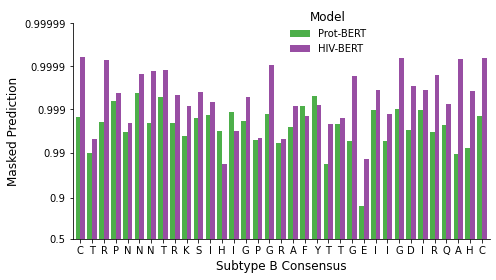

In [13]:
prob_ticks = [
    1 / 100000,
    1 / 10000,
    1 / 1000,
    1 / 100,
    1 / 10,
    1 / 2,
    9 / 10,
    99 / 100,
    999 / 1000,
    9999 / 10000,
    99999 / 100000,
]
ticks = logit(prob_ticks)

model_colors = sns.color_palette(MODEL_CMAP)[2:4]

fig, cons_ax = plt.subplots(1, 1, figsize=FULL_WIDTH_FIGSIZE)

cons_logit[['Prot-BERT', 'HIV-BERT']].plot(
    kind="bar", ax=cons_ax, color=model_colors,
    width = 0.8
)
cons_ax.set_xticklabels(consensus, rotation=0)
cons_ax.legend(title = 'Model', loc = 'upper left', bbox_to_anchor=(0.5, 1.1))
cons_ax.set_yticks(ticks[5:])
cons_ax.set_yticklabels(prob_ticks[5:])
cons_ax.set_ylabel("Masked Prediction")
cons_ax.set_xlabel("Subtype B Consensus")
sns.despine(ax=cons_ax)

fig.tight_layout()

In [14]:
try:
    fig.savefig(str(snakemake.output['masked_results']), dpi=300)
except NameError:
    fig.savefig("Fig5-masked_results-high.png", dpi=300)

In [15]:
targets = ["GagPol", "Vif", "Vpr", "Tat", "Rev", "Vpu", "Env", "Nef"]


def flatten_prots(examples):
    for p in targets:
        for prot in examples[p]:
            for aa in prot:
                yield aa


def chunkify(it, max_size):
    items = list(islice(it, max_size))
    while items:
        yield items
        items = list(islice(it, max_size))


def chunk_proteins(examples):
    chunks = chunkify(flatten_prots(examples), 128)
    return {"sequence": ["".join(c) for c in chunks]}

In [16]:
dataset = datasets.Dataset.load_from_disk(dataset_root + "FLT_genome")

chunked_set = dataset.map(
    chunk_proteins, remove_columns=dataset.column_names, batched=True
)

tkn_func = tokenize_function_factory(tokenizer=tokenizer, max_length=128)

tokenized_dataset = chunked_set.map(spacify_aa).map(tkn_func, batched=True)
split_dataset = tokenized_dataset.train_test_split()

Loading cached processed dataset at ../datasets/FLT_genome/cache-a67eee89264482cd.arrow
Loading cached processed dataset at ../datasets/FLT_genome/cache-9de43ff1d1f42875.arrow
Loading cached processed dataset at ../datasets/FLT_genome/cache-7f344299df0ea7c6.arrow
Loading cached split indices for dataset at ../datasets/FLT_genome/cache-2648a141a7909aa8.arrow and ../datasets/FLT_genome/cache-4904e7282fa76269.arrow


In [17]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm_probability=0.15, pad_to_multiple_of=8,
)

In [18]:
protbert_trainer = Trainer(
    model=protbert,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    data_collator=data_collator,
)

In [19]:
protbert_trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: sentence, sequence.
***** Running Evaluation *****
  Num examples = 7540
  Batch size = 8


{'eval_loss': 1.8521382808685303,
 'eval_runtime': 124.7162,
 'eval_samples_per_second': 60.457,
 'eval_steps_per_second': 7.561}

In [20]:
hivbert_trainer = Trainer(
    model=hivbert,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    data_collator=data_collator,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
hivbert_trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: sentence, sequence.
***** Running Evaluation *****
  Num examples = 7540
  Batch size = 8


{'eval_loss': 0.36859986186027527,
 'eval_runtime': 110.6004,
 'eval_samples_per_second': 68.173,
 'eval_steps_per_second': 8.526}

In [22]:
np.exp(-1.85), np.exp(-0.36)

(0.1572371663136276, 0.697676326071031)